In [10]:
# Basic Imports
import os, warnings, openpyxl
import nltk
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import pickle

# Data preparation and text-preprocessing
#import inflect, contractions, re, string, unicodedata, spacy
from bs4 import BeautifulSoup
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import LancasterStemmer
# from nltk.stem import WordNetLemmatizerd

warnings.filterwarnings("ignore")

data_dir = os.path.join(os.getcwd(), "Dataset")

In [4]:
nltk.download('all', quiet=True)
nltk.download('wordnet', quiet=True)

True

### Training Datasets

In [3]:
#3 Datasets
tweets_df = pd.read_csv(os.path.join(data_dir,'Tweets_Emotions.csv'))
emotions_df = pd.read_csv(os.path.join(data_dir, 'Emotions_from_text.csv'))
sentiment_df = pd.read_csv(os.path.join(data_dir,"Sentiment_140.csv"), names=["sentiment", "id", 'date',"query", "user", "content"])

In [4]:
#Check for null values
print("Tweets dataset\n", tweets_df.isnull().sum(),"\n")
print("Emotions dataset\n", emotions_df.isnull().sum(),"\n")
print("Sentiment\n", sentiment_df.isnull().sum(),"\n")

Tweets dataset
 tweet_id     0
sentiment    0
content      0
dtype: int64 

Emotions dataset
 Text       0
Emotion    0
dtype: int64 

Sentiment
 sentiment    0
id           0
date         0
query        0
user         0
content      0
dtype: int64 



In [5]:
print("Tweets dataset\n",tweets_df["sentiment"].unique(),"\n")
print("Emotions dataset\n",emotions_df["Emotion"].unique(),"\n")
def sentiments_df3(val):
    if val==0:
        return 'negative'
    elif val == 2:
        return 'neutral'
    elif val==4:
        return 'positive'

sentiment_df["sentiment"] = sentiment_df["sentiment"].apply(sentiments_df3)
print("Sentiment\n", sentiment_df["sentiment"].unique(),"\n")

Tweets dataset
 ['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger'] 

Emotions dataset
 ['sadness' 'anger' 'love' 'surprise' 'fear' 'happy'] 

Sentiment
 ['positive' 'negative' 'neutral'] 



In [6]:
#Removing unwanted columns
tweets_df.drop(["tweet_id"], axis=1, inplace=True)
tweets_df.drop(tweets_df.loc[tweets_df['sentiment']=='surprise'].index, inplace=True)
emotions_df.drop(emotions_df.loc[emotions_df['Emotion']=='surprise'].index, inplace=True)
sentiment_df.drop(["id", "date", "query", "user"], axis=1, inplace=True)

#Standardizing the sentiment column naming
emotions_df.rename(columns={"Emotion":"sentiment"}, inplace=True)
emotions_df.rename(columns={"Text":"content"}, inplace=True)

In [7]:
#Since we are trying to use emotins instead of sentiments, we will not use the sentiment_df
#Combining all the datasets
combined_df = pd.concat([tweets_df, emotions_df], ignore_index=True)

In [8]:
combined_df.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [9]:
#Classify the sentiment into positive and negative
def generalise_sentiment(text):
    if text=='love' or text=='positive' or text=='enthusiasm' or text =='surprise' or text=='fun 'or text=='happy' or text == 'happiness' or text=='relief':
        return 'positive'
    else:
        return 'negative'

combined_df["sentiment"] = combined_df["sentiment"].apply(generalise_sentiment)
combined_df["sentiment"].unique()

array(['negative', 'positive'], dtype=object)

In [9]:
combined_df["sentiment"].value_counts()

sadness       11430
neutral        8638
worry          8459
happy          7029
love           5483
happiness      5209
anger          3103
fear           2652
fun            1776
relief         1526
hate           1323
empty           827
enthusiasm      759
boredom         179
Name: sentiment, dtype: int64

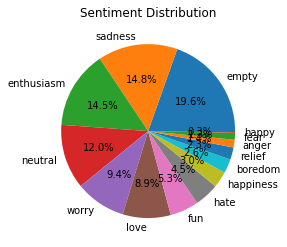

In [10]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title("Sentiment Distribution")
plt.pie(combined_df["sentiment"].value_counts(), labels=combined_df["sentiment"].unique(), autopct='%1.1f%%')
plt.show()

In [12]:
combined_df["char_len"] = combined_df["content"].apply(lambda x: len(x))
combined_df["token_len"] = combined_df["content"].apply(lambda x: len(x.split(" ")))

c:\Users\ezeki\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\ezeki\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


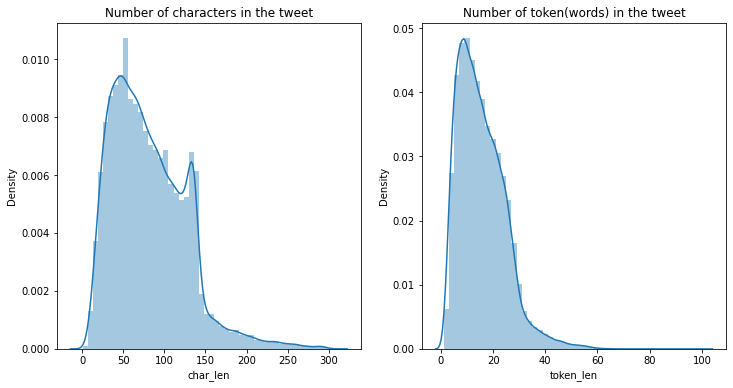

In [13]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.distplot(combined_df['char_len'], ax=ax1)
sns.distplot(combined_df['token_len'], ax=ax2)
ax1.set_title('Number of characters in the tweet')
ax2.set_title('Number of token(words) in the tweet')
plt.show()

In [14]:
mean_df = combined_df.groupby("sentiment").agg({"char_len":"mean", "token_len":"mean"})

C:\Users\ezeki\AppData\Local\Temp\ipykernel_11640\2646245128.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(mean_df.index, rotation = 45)
C:\Users\ezeki\AppData\Local\Temp\ipykernel_11640\2646245128.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(mean_df.index, rotation = 45)


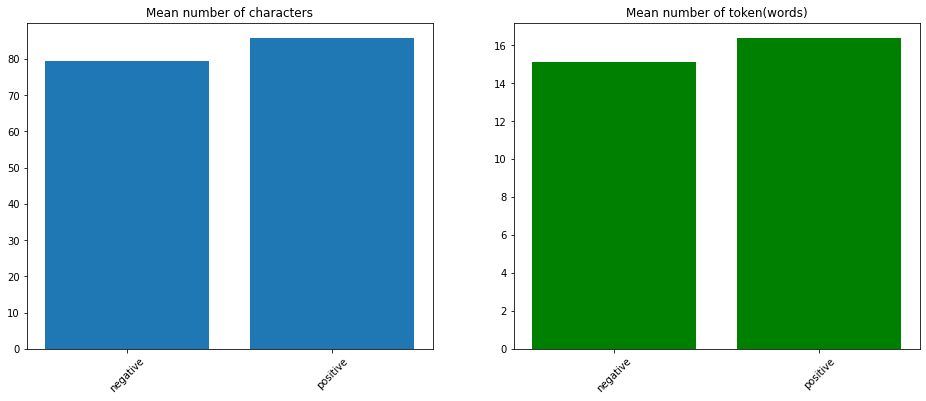

In [15]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.bar(mean_df.index, mean_df['char_len'])
ax2.bar(mean_df.index, mean_df['token_len'], color='green')
ax1.set_title('Mean number of characters')
ax2.set_title('Mean number of token(words)')
ax1.set_xticklabels(mean_df.index, rotation = 45)
ax2.set_xticklabels(mean_df.index, rotation = 45)
plt.show()

## Text Pre-Processing Function

In [11]:
def text_preprocessing_platform(df, text_col, remove_stopwords=True):
    ## Define functions for individual steps
    # First function is used to denoise text
    def denoise_text(text):
        # Strip html if any. For ex. removing <html>, <p> tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        # Replace contractions in the text. For ex. didn't -> did not
        text = contractions.fix(text)
        return text
    
    def remove_non_ascii(words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words
    
    def to_lowercase(words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words
    
    def remove_punctuation(words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words
    
    def replace_numbers(words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words
    
    def remove_stopwords(words):
        """Remove stop words from list of tokenized words"""
        new_words = []
        for word in words:
            if word not in stopwords.words('english'):
                new_words.append(word)
        return new_words
    
    def stem_words(words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer()
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems
    
    def lemmatize_verbs(words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas
    
    ### A wrap-up function for normalization
    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words)
        words = to_lowercase(words)
        words = remove_punctuation(words)
        words = replace_numbers(words)
        if remove_stopwords:
            words = remove_stopwords(words)
        #words = stem_words(words)
        words = lemmatize_verbs(words)
        return words

    # Tokenize tweet into words
    def tokenize(text):
        return nltk.word_tokenize(text)

    # A overall wrap-up function
    def text_prepare(text):
        text = denoise_text(text)
        text = ' '.join([x for x in normalize_text(tokenize(text), remove_stopwords)])
        return text
    
    # run every-step
    df[text_col] = [text_prepare(x) for x in df[text_col]]

    # return processed df
    return df

In [12]:
# Running text preprocessing on the combined dataset
print("Before Text Preprocessing")
display(combined_df.sample(5)[['content']])

processed_df = text_preprocessing_platform(combined_df, 'content', remove_stopwords=False)

print("After Text Preprocessing")
display(processed_df.sample(5)[['content']])

Before Text Preprocessing


,content
48227,im feeling and i say useless and he says that ...
22039,"@joshroyse Josh Excuse me, but, at what time ..."
34427,@pcsketch I'm considering buying one of these....
18693,@Candyland3 thats terrible.
42637,i would feel very ungrateful if i didnt thank ...


c:\Users\ezeki\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


After Text Preprocessing


,content
1181,almost everyone suck clit right people fuck
54168,really enjoy cabernet aggressive flavor tend e...
14249,santiaggo new yorker cover do iphone jealous o...
46945,feel like many years leave live content lay be...
6865,kujakupoet computer get screw hell viruses fin...


In [13]:
# Save the processed dataframe
processed_df.to_csv(os.path.join(data_dir,"emotions_processed_df.csv"), index=False)


In [14]:
processed_df.sample(5)

,sentiment,content
9016,worry,sfwa article language group spaceports look re...
17039,worry,o_0robertpatt
38612,happy,proud craft something people care even enough ...
24708,fun,aww sunshine life bob larry sing 70s make thin...
48854,happy,feel generous id treat friends dinner bbq home...


### Can read processed text directly into dataframe

In [3]:
processed_df = pd.read_csv(os.path.join(data_dir,"emotions_processed_df.csv"))

In [4]:
processed_df.dropna(inplace=True)
processed_df.isnull().sum()

sentiment    0
content      0
dtype: int64

In [5]:
processed_df.sample(5)

,sentiment,content
3645,love,ughcold dank
41210,sadness,feel inadequate moments momma
5454,neutral,kimkardashian watchin tv yesterday media numbe...
44750,love,feel value need shift direction care things ea...
6168,worry,believe shit spend thirty minutes snicker ice ...


## Train Test Split

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(processed_df['sentiment'])
X = processed_df.iloc[:,1:2]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=7)

In [6]:
X_train['content'][0]

'tiffanylue know listenin bad habit earlier start freakin part'

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_train_bow = cv.fit_transform(X_train['content']).toarray()
X_test_bow = cv.transform(X_test['content']).toarray()

In [9]:
import pickle
pickle.dump(cv, open("cv (selected) emotions.pkl", "wb"))

In [8]:
X_test_bow[0].shape

(43346,)

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(processed_df['sentiment'])
le_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))
#print(le_name_mapping)

class_name = []

#print both key and value from mapping 
for key, value in le_name_mapping.items():
    print(key, value)
    class_name.append(value)
    
    


0 anger
1 boredom
2 empty
3 enthusiasm
4 fear
5 fun
6 happiness
7 happy
8 hate
9 love
10 neutral
11 relief
12 sadness
13 worry


In [13]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Logistic Regression 

### One vs rest (OVR)

In [10]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class='ovr', C=1)
lr.fit(X_train_bow,y_train)

LogisticRegression(C=1, multi_class='ovr')

In [11]:
lr = pickle.load(open("logistic_regression-ovr-c1_emotions.pkl", "rb"))

 Accuracy 0.5303
 Precision 0.5144 
 Recall 0.5303 
 F1 0.513

Confusion Matrix:
 [[ 492    0    0    0   21    0    2   15    1    7   25    2   52   18]
 [   1    0    0    0    0    1    4    0    2    1   17    1   10    8]
 [   1    1    1    0    0    0   14    0    1    4   90    0   14   40]
 [   0    0    0    0    1    5   16    5    2    7   75    1   13   34]
 [  22    0    1    0  414    0    1   11    0    2    9    0   22    8]
 [   1    0    1    1    1   16   77    2    5   28  131    3   27   62]
 [   2    1    0    3    1   20  328   22    4  126  348    7   58  137]
 [  10    0    0    0   20    0    5 1272    0   56   14    0   37    9]
 [   1    1    1    0    1    3   10    0   47    3   52    2   63   86]
 [   7    0    0    0    3   12  131  100    5  519  161   11   64   99]
 [   2    0    0    1    3   10  121   19   10   50 1015   13  128  328]
 [   2    0    2    0    1    2   57   11    3   19  126   16   17   59]
 [  33    0    0    0   32    4   44   41 

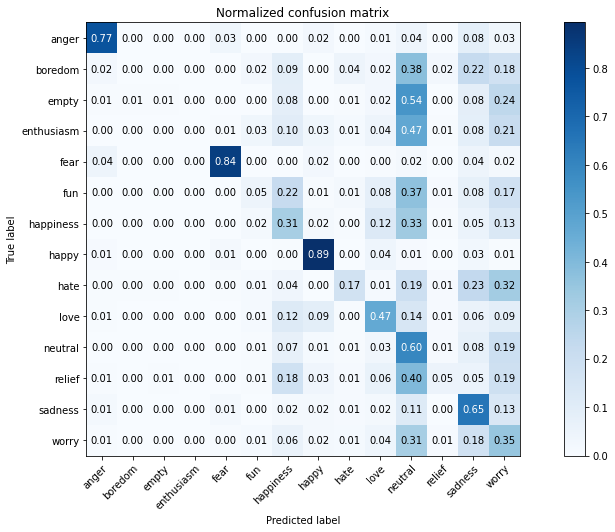

In [16]:
#ovr
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score, precision_score, recall_score
y_pred = lr.predict(X_test_bow)
lr_ovr_accuracy = round(accuracy_score(y_test,y_pred),4)
lr_ovr_precision = round(precision_score(y_test,y_pred,average='weighted'),4)
lr_ovr_recall = round(recall_score(y_test,y_pred,average='weighted'),4)
lr_ovr_f1_score = round(f1_score(y_test,y_pred,average='weighted'),4)
print(" Accuracy", lr_ovr_accuracy)
print(" Precision",lr_ovr_precision,"\n","Recall",lr_ovr_recall,"\n","F1",lr_ovr_f1_score)
#print(confusion_matrix(y_test, y_pred))
# #Confusion Matrix
# lr_ovr_tn, lr_ovr_fp, lr_ovr_fn, lr_ovr_tp = confusion_matrix(y_test, y_pred).ravel()

# #measurements
# lr_ovr_accuracy = (lr_ovr_tp+lr_ovr_tn)/(lr_ovr_tp+lr_ovr_tn+lr_ovr_fp+lr_ovr_fn)
# print(" Accuracy", lr_ovr_accuracy)
# lr_ovr_precision = lr_ovr_tp/(lr_ovr_tp+lr_ovr_fp)
# lr_ovr_recall = lr_ovr_tp/(lr_ovr_tp+lr_ovr_fn)
# lr_ovr_f1_score = (2*lr_ovr_precision)*(lr_ovr_recall)/(lr_ovr_precision+lr_ovr_recall)
# print(" Precision",lr_ovr_precision,"\n","Recall",lr_ovr_recall,"\n","F1",lr_ovr_f1_score)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_name, normalize=True, title='Normalized confusion matrix')
plt.show()

In [14]:
import pickle
# save the model to disk
filename = 'logistic_regression-ovr-c1_emotions.pkl'
pickle.dump(lr, open(filename, 'wb'))

In [23]:
import gc
del lr
gc.collect()

7

### Multinomial

In [16]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class='multinomial', C=1)
lr.fit(X_train_bow,y_train)

LogisticRegression(C=1, multi_class='multinomial')

In [17]:
lr = pickle.load(open("logistic_regression-multinomial-c1_emotions.pkl", "rb"))

 Accuracy 0.5223
 Precision 0.5083 
 Recall 0.5223 
 F1 0.5076

Confusion Matrix:
 [[ 488    0    0    0   17    0    1   17    1   10   25    2   55   19]
 [   1    0    1    0    0    0    3    0    2    0   18    1   12    7]
 [   1    1    1    0    0    2   13    0    2    4   91    0   13   38]
 [   0    0    0    1    0    6   18    4    1    5   71    2   16   35]
 [  24    0    0    1  406    0    0   12    0    4    9    0   25    9]
 [   1    0    1    0    0   23   69    3    5   32  128    3   25   65]
 [   2    1    0    3    0   29  324   15    4  125  344   12   62  136]
 [   9    0    1    0   21    0    7 1256    0   69   13    0   39    8]
 [   1    1    1    0    1    4   11    1   49    3   48    2   71   77]
 [   6    0    0    0    3   16  137  101    3  508  160   13   68   97]
 [   1    1    4    2    3   21  129   10   14   60  983   16  136  320]
 [   2    0    1    1    0    7   52   10    5   27  121   15   15   59]
 [  40    0    1    0   33    9   43   47

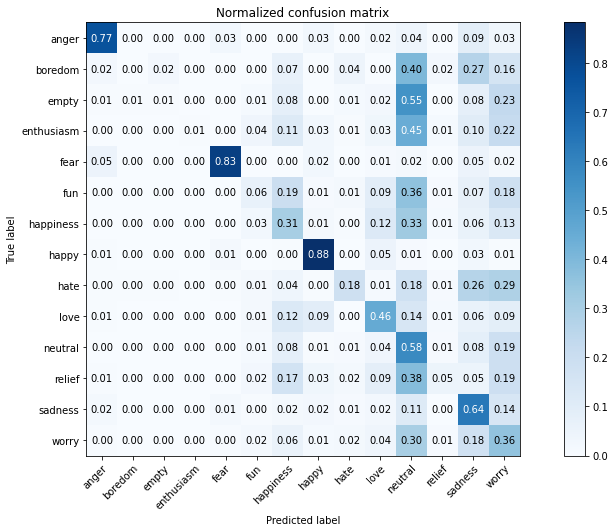

In [18]:
#multinomial
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score, precision_score, recall_score
y_pred = lr.predict(X_test_bow)
lr_mn_accuracy = round(accuracy_score(y_test,y_pred),4)
lr_mn_precision = round(precision_score(y_test,y_pred,average='weighted'),4)
lr_mn_recall = round(recall_score(y_test,y_pred,average='weighted'),4)
lr_mn_f1_score = round(f1_score(y_test,y_pred,average='weighted'),4)
print(" Accuracy", lr_mn_accuracy)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

# #Confusion Matrix
# lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()

# #measurements
# lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
# print(" Accuracy", lr_mn_accuracy)
# lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
# lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
# lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
# print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_name, normalize=True, title='Normalized confusion matrix')
plt.show()

In [19]:
import pickle
# save the model to disk
filename = 'logistic_regression-multinomial-c1_emotions.pkl'
pickle.dump(lr, open(filename, 'wb'))

In [20]:
import gc
del lr
gc.collect()

55

## Naive Bayes

In [24]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_bow,y_train)

MultinomialNB()

In [21]:
mnb = pickle.load(open("multinomialNB_emotions.pkl", "rb"))

 Accuracy 0.4239
 Precision 0.413 
 Recall 0.4239 
 F1 0.384

Confusion Matrix:
 [[ 182    0    0    0   10    0    2   83    0    3    6    0  328   21]
 [   0    0    0    0    0    0    3    2    0    0    5    0   22   13]
 [   0    0    0    0    0    0    9    5    0    3   47    0   58   44]
 [   0    0    0    0    0    0   24   14    0   12   32    0   39   38]
 [  10    0    0    0  132    0    0   88    0    1    1    0  247   11]
 [   0    0    0    0    0    0   54   15    0   25   83    0   79   99]
 [   0    0    0    0    0    0  242   43    0  125  217    0  185  245]
 [   2    0    0    0    1    0    2 1204    0    9    6    0  193    6]
 [   0    0    0    0    0    0    3    4    0    2   29    0  125  107]
 [   0    0    0    0    0    0  101  192    0  349   94    0  254  122]
 [   2    0    0    0    2    0   92   60    1   65  471    1  545  461]
 [   0    0    0    0    0    0   40   17    0   12   66    0   87   93]
 [   5    0    0    0    3    0   24   60  

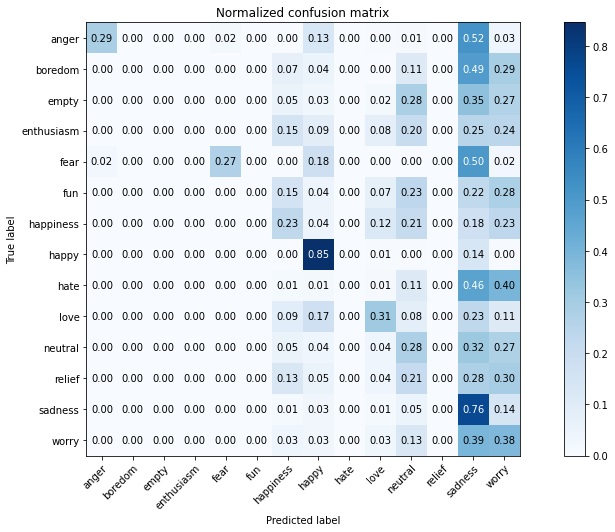

In [22]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score, precision_score, recall_score
y_pred = mnb.predict(X_test_bow)
mnb_accuracy = round(accuracy_score(y_test,y_pred),4)
mnb_precision = round(precision_score(y_test,y_pred,average='weighted'),4)
mnb_recall = round(recall_score(y_test,y_pred,average='weighted'),4)
mnb_f1_score = round(f1_score(y_test,y_pred,average='weighted'),4)
print(" Accuracy", mnb_accuracy)
print(" Precision",mnb_precision,"\n","Recall",mnb_recall,"\n","F1",mnb_f1_score)

# #Confusion Matrix
# mnb_tn, mnb_fp, mnb_fn, mnb_tp = confusion_matrix(y_test, y_pred).ravel()

# #measurements
# mnb_accuracy = (mnb_tp+mnb_tn)/(mnb_tp+mnb_tn+mnb_fp+mnb_fn)
# print(" Accuracy", mnb_accuracy)
# mnb_precision = mnb_tp/(mnb_tp+mnb_fp)
# mnb_recall = mnb_tp/(mnb_tp+mnb_fn)
# mnb_f1_score = (2*mnb_precision)*(mnb_recall)/(mnb_precision+mnb_recall)
# print(" Precision",mnb_precision,"\n","Recall",mnb_recall,"\n","F1",mnb_f1_score)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_name, normalize=True, title='Normalized confusion matrix')
plt.show()

In [27]:
import pickle
# save the model to disk
filename = 'multinomialNB_emotions.pkl'
pickle.dump(mnb, open(filename, 'wb'))

In [28]:
import gc
del mnb
gc.collect()

469

## Linear SVC

In [29]:
from sklearn.svm import LinearSVC
svc=LinearSVC(random_state=7)
svc.fit(X_train_bow, y_train)

LinearSVC(random_state=7)

In [23]:
svc = pickle.load(open("linear_svc_emotions.pkl", "rb"))

 Accuracy 0.4914
 Precision 0.4699 
 Recall 0.4914 
 F1 0.4782

Confusion Matrix:
 [[ 482    0    3    0   21    0    5   20    3    9   20    7   49   16]
 [   2    0    1    0    0    2    1    1    2    1    9    1   17    8]
 [   2    3    2    1    0    3   20    1    3    7   73    0   18   33]
 [   0    0    2    2    2    7   26    4    1    7   62    5   19   22]
 [  28    0    1    0  409    0    1   12    0    4    3    1   22    9]
 [   1    2    5    1    2   18   66    8    7   34  117   15   24   55]
 [   3    1    8   13    1   43  287   39    8  144  278   19   79  134]
 [  10    0    1    2   25    4   12 1232    0   67    7    1   49   13]
 [   6    1    6    1    1    5   11    1   48    8   46    4   60   72]
 [   9    0    4    4    5   28  106  110    5  488  145   23   89   96]
 [  13    0   13   14    6   47  139   22   24   84  800   39  169  330]
 [   4    3    3    5    1    8   53   14    7   35   93   13   25   51]
 [  50    1    9    2   33    9   40   45

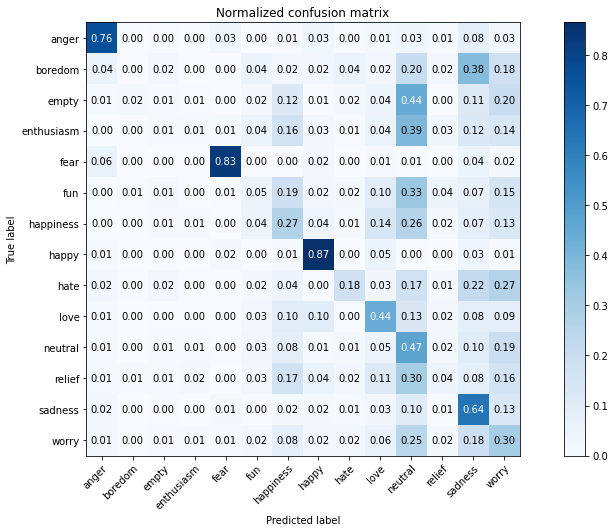

In [24]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score, precision_score, recall_score
y_pred = svc.predict(X_test_bow)
svc_accuracy = round(accuracy_score(y_test,y_pred),4)
svc_precision = round(precision_score(y_test,y_pred,average='weighted'),4)
svc_recall = round(recall_score(y_test,y_pred,average='weighted'),4)
svc_f1_score = round(f1_score(y_test,y_pred,average='weighted'),4)
print(" Accuracy", svc_accuracy)
print(" Precision",svc_precision,"\n","Recall",svc_recall,"\n","F1",svc_f1_score)


print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_name, normalize=True, title='Normalized confusion matrix')
plt.show()

In [32]:
import pickle
# save the model to disk
filename = 'linear_svc_emotions.pkl'
pickle.dump(svc, open(filename, 'wb'))

## Results

In [1]:
# metric_data = [["Logistic Regression (OVR)", lr_ovr_accuracy, lr_ovr_precision, lr_ovr_recall, lr_ovr_f1_score], ["Logistic Regression (Multinomial)", lr_mn_accuracy, lr_mn_precision, lr_mn_recall, lr_mn_f1_score], ["Multinomial Naive Bayes", mnb_accuracy, mnb_precision, mnb_recall, mnb_f1_score]]
# res_df = pd.DataFrame(metric_data, columns=['Classifier', 'Accuracy Score', 'Precision', 'Recall', 'F-Measure'])
# res_df